In [12]:
import pydantic
import cudf
import cugraph
from tqdm import tqdm

from gnn_tracking.training.ml import MLModule
from pathlib import Path
from torch_cluster import radius_graph
import pandas as pd
import torch
from gnn_tracking.utils.timing import Timer
from gnn_tracking.metrics.cluster_metrics import tracking_metric_df
import matplotlib.pyplot as plt
import numpy as np



In [13]:
model_exchange_path = Path(
    "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/model_exchange"
)

In [ ]:
from gnn_tracking.utils.loading import TrackingDataModule

dm = TrackingDataModule(
    train=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_1/"
        ],
        # If you run into memory issues, reduce this
    ),
    val=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9/"
        ],
        stop=5
    ),
)

In [ ]:
dm.setup(stage="fit")

In [16]:
model = MLModule.load_from_checkpoint(model_exchange_path / "gc" / "gc-7dce6aff.ckpt")

[15:22:14] DEBUG: Getting class GraphConstructionFCNN from module gnn_tracking.models.graph_construction
[15:22:14] DEBUG: Getting class GraphConstructionHingeEmbeddingLoss from module gnn_tracking.metrics.losses


In [17]:
data = dm.datasets["train"][1]
out = model(data)
len(data.x)

64253

In [18]:
h = out["H"].detach()

## Testing cluster scanning with jian's accelerated dbscan rescanner

In [19]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster._dbscan_inner import dbscan_inner
from sklearn.cluster import DBSCAN

class DBSCANFastRescan:

    def __init__(self, X, max_eps=1, n_jobs=None):
        """Class to perform DBSCAN clustering with fast rescanning.
        Args:
            X: Data to cluster
            max_eps: Maximum epsilon to use during rescanning. Set to as low
                as possible to save time.
            n_jobs : int, default=None
                The number of parallel jobs to run.
        """
        self.X = X
        self.max_eps = max_eps
        self.n_jobs=n_jobs
        self._reset_graph(max_eps)

    def _reset_graph(self, max_eps):
        """
        Set and store the radius_neighbors graph to use for clustering.
        """
        neighbors_model = NearestNeighbors(radius=max_eps)
        neighbors_model.fit(self.X)
        distances, indexes = neighbors_model.radius_neighbors(self.X, radius=max_eps, return_distance=True)

        lengths = [len(arr) for arr in indexes]
        source_indexes = np.repeat(np.arange(len(indexes)), lengths)
        target_indexes = np.concatenate(indexes)

        self.distances = np.concatenate(distances)
        self.edges = np.column_stack((source_indexes, target_indexes))

    def cluster(self, eps = 1, min_pts= 1):
        """Perform clustering on given data with DBSCAN
        Args:
            eps: Epsilon to use for clustering
            min_pts: Minimum number of points to form a cluster
        """
        if(eps > self.max_eps):
            self._reset_graph(eps)

        filtered_edges = self.edges[self.distances <= eps]

        n_neighbors = np.bincount(filtered_edges[:,0])
        core_samples = np.asarray(n_neighbors >= min_pts, dtype=np.uint8)

        idx = np.where(np.diff(filtered_edges[:,0]) != 0)[0] + 1
        neighborhoods = np.array(np.split(filtered_edges[:,1], idx), dtype="object")

        labels = np.full(len(self.X), -1, dtype=np.intp)

        dbscan_inner(core_samples, neighborhoods, labels)

        return labels

In [31]:
class ScanExecutor:
    def __init__(self, epsilon_range=(0, 1), n_samples=100):
        self._n_samples = n_samples
        self._epsilon_range = epsilon_range
        self._epsilons = np.linspace(*epsilon_range, n_samples)
        self._results = []

    def scan(self, data, out):
        scanner = self.init_clusterer(data, out)
        results = []
        for eps in tqdm(self._epsilons):
            labels =scanner.cluster(eps=eps)
            tdf = pd.DataFrame({"c": labels, "id": data.particle_id.detach().numpy()})
            tmdf = tracking_metric_df(tdf)
            results.append(tmdf["double_majority"].sum())
        self._results.append(np.array(results))

    def init_clusterer(self, data, out):
        return DBSCANFastRescan(out["H"].detach().numpy())

    def get_best_result_and_reset(self):
        average = np.array(self._results).mean(axis=0)
        best_result = average.max()
        best_epsilon = self._epsilons[average.argmax()]

In [32]:
se = ScanExecutor(np.linspace(0.01, 1., 100))
for data in dm.val_dataloader():
    out = model(data)
    se.scan(data, out)

 38%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 38/100 [00:05<00:08,  7.59it/s]


KeyboardInterrupt: 

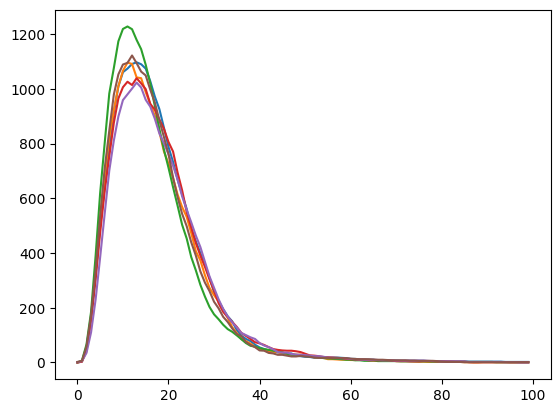

In [33]:
for rs in se._results:
    plt.plot(rs)

## Testing radius graph instead of dbscan

In [79]:
def torch_to_cudf(tensor_dict):
    return cudf.DataFrame(
        {
            k: cudf.from_dlpack(torch.utils.dlpack.to_dlpack(v))
            for k, v in tensor_dict.items()
        }
    )

In [80]:
def collect_cluster_labels_gpu(h, radius=1):
    """Implementation with radius graph"""
    t = Timer()
    times = []
    h = h.detach()
    times.append(t())
    edge_index = radius_graph(h, r=radius)
    times.append(t())
    edge_df = torch_to_cudf({"source": edge_index[0], "destination": edge_index[1]})
    times.append(t())
    cug = cugraph.Graph()
    times.append(t())
    cug.from_cudf_edgelist(edge_df)
    times.append(t())
    cc_df = cugraph.connected_components(cug)
    times.append(t())
    return cc_df["labels"], times

In [81]:
collect_cluster_labels_gpu(h, radius=1)[1]

[7.193395867943764e-05,
 1.0180357589852065,
 0.03350605897139758,
 8.085044100880623e-06,
 0.10735613503493369,
 0.04444553900975734]

In [82]:
from gnn_tracking.postprocessing.dbscanscanner import dbscan

In [83]:
t = Timer()
labels = torch.Tensor(dbscan(h, eps=0.3)).to("cuda")
t()

0.8764291900442913

In [84]:
len(labels.unique())

3913

In [85]:
dm.datasets["val"][0]

Data(x=[59357, 14], edge_index=[2, 203759], y=[0], layer=[59357], particle_id=[59357], pt=[59357], reconstructable=[59357], sector=[59357])

In [86]:
cdf = torch_to_cudf({"c": labels, "id": data.particle_id})
df = pd.DataFrame({"c": labels.cpu().numpy(), "id": data.particle_id.cpu().numpy()})

In [87]:
len(df)

64253

## Testing track metrics on the GPU

In [88]:
from collections import Counter
import pandas as pd
import numpy as np


def tracking_metric_df_cuda(h_df: pd.DataFrame, predicted_count_thld=3) -> pd.DataFrame:
    """Label clusters as double majority/perfect/LHC.

    Args:
        h_df: Hit information dataframe
        predicted_count_thld: Number of hits a cluster must have to be considered a
            valid cluster

    Returns:
        cluster dataframe with columns such as "double_majority" etc.
    """
    # For each cluster, we determine the true PID that is associated with the most
    # hits in that cluster.
    # Here we make use of the fact that `df.value_counts` sorts by the count.
    # That means that if we group by the cluster and take the first line
    # for each of the counts, we have the most popular PID for each cluster.
    # The resulting dataframe now has both the most popular PID ("id" column) and the
    # number of times it appears ("0" column).
    # This strategy is a significantly (!) faster version than doing
    # c_id.groupby("c").agg(lambda x: x.mode()[0]) etc.
    pid_counts = h_df[["c", "id"]].value_counts().reset_index()

    # Compatibility issue with pandas 2.0 (2.0 uses 'count')
    _count_key = 0 if 0 in pid_counts.columns else "count"

    pid_counts_grouped = pid_counts.groupby("c")
    c_df = pid_counts_grouped.first().rename(
        {"id": "maj_pid", _count_key: "maj_hits"}, axis=1
    )
    # Number of hits per cluster
    c_df["cluster_size"] = pid_counts_grouped[_count_key].sum()
    # Assume that negative cluster labels mean that the cluster was labeled as
    # invalid
    predicted_counts = h_df["c"].value_counts()
    unique_predicted = predicted_counts.index
    # Cluster mask: all clusters that are not labeled as noise and have minimum number
    # of hits.
    c_df["valid_cluster"] = (unique_predicted >= 0) & (
        predicted_counts >= predicted_count_thld
    )

    # Properties associated to PID. This is pretty trivial, but since everything is
    # passed by hit, rather than by PID, we need to get rid of "duplicates"
    particle_properties = list(
        {"pt", "reconstructable", "eta"}.intersection(h_df.columns)
    )
    # Could to .first() for pt/reconstructable, but we want to average over eta
    pid_to_props = (
        h_df[["id", *particle_properties]].groupby("id")[particle_properties].mean()
    )
    c_df = c_df.merge(
        pid_to_props, left_on="maj_pid", right_index=True
    ).rename(columns={key: f"maj_{key}" for key in particle_properties})

    # For each PID: Number of hits (in any cluster)
    pid_to_count = h_df["id"].value_counts()
    # For each cluster: Take most popular PID of that cluster and get number of hits of
    # that PID (in any cluster)
    c_df["maj_pid_hits"] = c_df["maj_pid"].map(pid_to_count)

    # For each cluster: Fraction of hits that have the most popular PID
    c_df["maj_frac"] = (c_df["maj_hits"] / c_df["cluster_size"]).fillna(0)
    # For each cluster: Take the most popular PID of that cluster. What fraction of
    # the corresponding hits is in this cluster?
    c_df["maj_pid_frac"] = (c_df["maj_hits"] / c_df["maj_pid_hits"]).fillna(0)

    c_df["perfect_match"] = (
        (c_df["maj_pid_hits"] == c_df["maj_hits"])
        & (c_df["maj_frac"] > 0.99)
        & c_df["valid_cluster"]
    )
    c_df["double_majority"] = (
        (c_df["maj_pid_frac"] > 0.5) & (c_df["maj_frac"] > 0.5) & c_df["valid_cluster"]
    )
    c_df["lhc_match"] = (c_df["maj_frac"] > 0.75) & c_df["valid_cluster"]
    return c_df

In [91]:
t = Timer()
tmdf = tracking_metric_df_cuda(cdf)
t(), tmdf["double_majority"].sum()

(0.02284119196701795, 139)

In [92]:
t = Timer()
tmdf = tracking_metric_df(df)
t(), tmdf["double_majority"].sum()

(0.026246000081300735, 225)

## Testing clustering on GPU

In [67]:
def tensor_to_cudf(t):
    return torch_to_cudf({"i": t[:, i].squeeze() for i in range(t.shape[1])})

In [68]:
cuh = cudf.from_dlpack(torch.utils.dlpack.to_dlpack(h.T)).T

In [69]:
import cuml
from cuml.cluster import DBSCAN

In [70]:
cpid= cudf.from_dlpack(torch.utils.dlpack.to_dlpack(data.particle_id))

In [71]:
def get_dm(radius=1, ):
    dbscan = DBSCAN(eps=radius, min_samples=1)
    r = dbscan.fit(cuh, out_dtype='int64')
    labels = r.labels_
    tdf = cudf.DataFrame({"c": labels, "id": cpid})
    tmdf = tracking_metric_df_cuda(tdf)
    return tmdf["double_majority"].sum()


In [72]:
t = Timer()
results2 = []
eps = np.linspace(0.01, 1., 100)
for r in eps:
    results2.append(get_dm(r))
t()

8.731808774988167

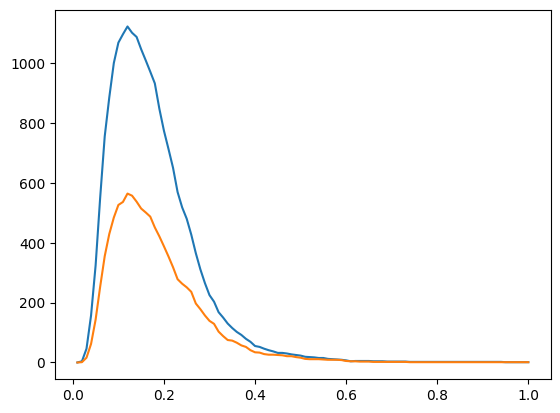

In [73]:
plt.plot(eps, results)
plt.plot(eps, results2)